* tflite python docs -> https://www.tensorflow.org/lite/guide/inference#load_and_run_a_model_in_python
* example we are working from -> https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/examples/python

Download labels:
```
curl https://storage.googleapis.com/download.tensorflow.org/models/mobilenet_v1_1.0_224_frozen.tgz  | tar xzv -C /tmp  mobilenet_v1_1.0_224/labels.txt
```

In [1]:
import argparse
import numpy as np
import os
from PIL import Image

import tflite_runtime.interpreter as tflite

In [2]:
all_models_dir = '/home/pi/github/edgetpu/test_data/'

In [3]:
image = all_models_dir + 'parrot.jpg'
image

'/home/pi/github/edgetpu/test_data/parrot.jpg'

In [4]:
model_file = all_models_dir + 'mobilenet_v1_1.0_224_quant.tflite'
model_file

'/home/pi/github/edgetpu/test_data/mobilenet_v1_1.0_224_quant.tflite'

In [5]:
label_file = 'mobilenet_v1_1.0_224/labels.txt'
label_file

'mobilenet_v1_1.0_224/labels.txt'

In [6]:
def load_labels(filename):
    with open(filename, 'r') as f:
        return [line.strip() for line in f.readlines()]
    
labels = load_labels(label_file)

In [7]:
interpreter = tflite.Interpreter(model_path=model_file)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [8]:
input_details

[{'name': 'input',
  'index': 88,
  'shape': array([  1, 224, 224,   3]),
  'dtype': numpy.uint8,
  'quantization': (0.0078125, 128)}]

In [9]:
output_details

[{'name': 'MobilenetV1/Predictions/Reshape_1',
  'index': 87,
  'shape': array([   1, 1001]),
  'dtype': numpy.uint8,
  'quantization': (0.00390625, 0)}]

In [10]:
# check the type of the input tensor
floating_model = input_details[0]['dtype'] == np.float32
floating_model

False

In [11]:
# NxHxWxC, H:1, W:2
height = input_details[0]['shape'][1]
print(height)
width = input_details[0]['shape'][2]
img = Image.open(image).resize((width, height))

224


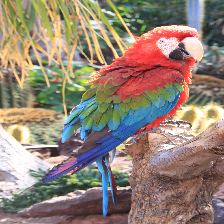

In [12]:
img

In [13]:
# add N dim
input_data = np.expand_dims(img, axis=0)

In [14]:
input_data.shape

(1, 224, 224, 3)

In [15]:
if floating_model:
    input_data = (np.float32(input_data) - input_mean) / input_std

In [16]:
%%time
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 155 ms, sys: 1.12 ms, total: 156 ms
Wall time: 154 ms


In [17]:
output_data.shape

(1, 1001)

In [18]:
output_data.max()

255

In [19]:
results = np.squeeze(output_data)

In [20]:
results.shape

(1001,)

In [21]:
results.max()

255

Get the index of the top results

In [22]:
top_k = results.argsort()[-5:][::-1]
top_k

array([  89, 1000,  329,  341,  340], dtype=int32)

In [23]:
for i in top_k:
    if floating_model:
        print('{:08.6f}: {}'.format(float(results[i]), labels[i]))
    else:
        print('{:08.6f}: {}'.format(float(results[i] / 255.0), labels[i]))

1.000000: 89:macaw
0.000000: 1000:toilet tissue, toilet paper, bathroom tissue
0.000000: 329:sea urchin
0.000000: 341:zebra
0.000000: 340:sorrel
